In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ""

/home/gj/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/gj/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
tf.__version__

'2.0.0-beta0'

In [3]:
@tf.function
def distance_matrix(pos_vector):
    r = tf.reduce_sum(pos_vector*pos_vector, 1)
    r = tf.reshape(r, [-1, 1])
    D = r - 2*tf.matmul(pos_vector, tf.transpose(pos_vector)) + tf.transpose(r)
    return tf.sqrt(D)

@tf.function
def potential_field(m_vector, pos_vector):

    num_particles = m_vector.shape[0]
    mask = tf.reshape(tf.range(num_particles),(1,-1) ) < tf.reshape(tf.range(num_particles), (-1,1))

    dist = tf.boolean_mask(distance_matrix(pos_vector), mask)
    masses =  tf.boolean_mask(tf.tensordot(m_vector, m_vector, axes = 0), mask)
    
    return -1 * tf.reduce_sum(masses/dist)
    
    

In [4]:
@tf.function
def step(pos_vector, vel_vector, step_size = 1e-6, number_of_steps = 10000):
    
    for i in tf.range(number_of_steps):

        with tf.GradientTape() as tape:
            tape.watch(pos_vector)
            V = potential_field(m_vector,pos_vector)

        grad = tape.gradient(V, pos_vector)

        acceleration = -1* grad/tf.expand_dims(m_vector, axis = 1)   

        pos_vector = pos_vector + step_size*vel_vector
        vel_vector = vel_vector + step_size*acceleration
        
    return pos_vector, vel_vector
    

In [5]:
m_vector = tf.constant(np.array([1000000., 100., 1.]), dtype= tf.float64)
pos_vector = tf.Variable(np.array([[0, 0], [0, 50], [0, -25]]), dtype= tf.float64)
vel_vector = tf.Variable(np.array([[0, 0], [-160,0], [250, 0]]), dtype= tf.float64)

path = [pos_vector.numpy()]


In [6]:
for i in tqdm.trange(500):

    pos_vector, vel_vector = step(pos_vector, vel_vector)
    path.append(pos_vector.numpy())
        

  0%|          | 0/500 [00:00<?, ?it/s]WARNING: Logging before flag parsing goes to stderr.
W0610 21:54:45.999586 139793426790144 deprecation.py:323] From /home/gj/miniconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py:1340: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
100%|██████████| 500/500 [03:45<00:00,  2.23it/s]


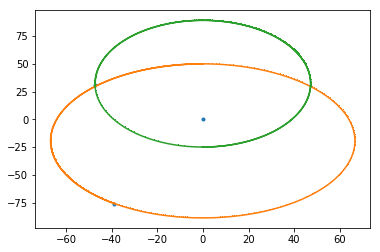

In [7]:
to_plot = np.stack(path)
plt.plot(to_plot[:,:,0], to_plot[:,:,1], marker = ',')
plt.scatter(to_plot[-1,:,0], to_plot[-1,:,1], marker = '.')
plt.show()